## MNIST FEEDFORWARD NETWORK
This notebook is my first attempt at implementing feedforward network. 
This is done on the MNIST dataset. 

In [ ]:
# Packages 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [14]:
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


In [15]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL image to tensor (0-1 range)
    transforms.Normalize((0.5,), (0.5,))  # Normalize to (-1, 1) range
])

# Load training data
train_dataset = datasets.MNIST(
    root='./data',           # Where to download/store data
    train=True,              # Load training set
    download=True,           # Download if not present
    transform=transform      # Apply transforms
)

# Load test data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,             # Load test set
    download=True,
    transform=transform
)

# Create data loaders for batching
train_loader = DataLoader(
    train_dataset,
    batch_size=64,           # Number of samples per batch
    shuffle=True             # Shuffle training data
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,           # Number of samples per batch
    shuffle=True             # Shuffle training data
)

In [ ]:
# 1. Define model
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        # Defining the different layers 
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self._init_weights()

    # Initialize the weight and bias for each linear layer 
    def _init_weights(self):
        for layer in [self.fc1, self.fc2, self.fc3]:
            nn.init.kaiming_normal_(layer.weight)
            layer.bias.data.zero_()
 
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def evaluate(model, dataloader, loss_fn):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            total_loss += loss.item() * x_batch.size(0)
            _, pred_class = pred.max(1)
            total_correct += (pred_class == y_batch).sum().item()
            total += x_batch.size(0)

    avg_loss = total_loss / total
    error = 100 - 100 * total_correct / total
    return avg_loss, error

# 3. Create model, loss, optimizer
# initalizae the model 
model = NN()
# Loss function 
loss_function = nn.CrossEntropyLoss()
# Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  

# Number of epochs 
n_epoch = 30

# Storing the loss and error to be printed 
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_test = np.zeros((n_epoch))
errors_test = np.zeros((n_epoch))

for epoch in range(n_epoch):
    # Train the model 
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        loss = loss_function(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()

    # Append to the list 
    losses_train[epoch], errors_train[epoch] = evaluate(model, train_loader, loss_function)
    losses_test[epoch],  errors_test[epoch]  = evaluate(model, test_loader, loss_function)

    # Print each the loss and error for each epoch 
    print(
        f"Epoch {epoch:3d} | "
        f"train loss {losses_train[epoch]:.4f}, train error {errors_train[epoch]:5.2f}% | "
        f"test loss {losses_test[epoch]:.4f}, test error {errors_test[epoch]:5.2f}%"
    )

Epoch   0 | train loss 0.1664, train error  5.23% | test loss 0.1593, test error  5.05%
Epoch   1 | train loss 0.1143, train error  3.63% | test loss 0.1295, test error  4.19%
Epoch   2 | train loss 0.0852, train error  2.64% | test loss 0.1067, test error  3.13%
Epoch   3 | train loss 0.0658, train error  2.10% | test loss 0.0935, test error  2.90%
Epoch   4 | train loss 0.0636, train error  2.10% | test loss 0.1000, test error  3.14%
Epoch   5 | train loss 0.0659, train error  2.20% | test loss 0.1088, test error  3.40%
Epoch   6 | train loss 0.0455, train error  1.45% | test loss 0.0876, test error  2.64%
Epoch   7 | train loss 0.0470, train error  1.57% | test loss 0.0819, test error  2.43%
Epoch   8 | train loss 0.0397, train error  1.28% | test loss 0.0786, test error  2.39%
Epoch   9 | train loss 0.0529, train error  1.83% | test loss 0.0963, test error  3.09%
Epoch  10 | train loss 0.0337, train error  1.13% | test loss 0.0840, test error  2.40%
Epoch  11 | train loss 0.0485, t

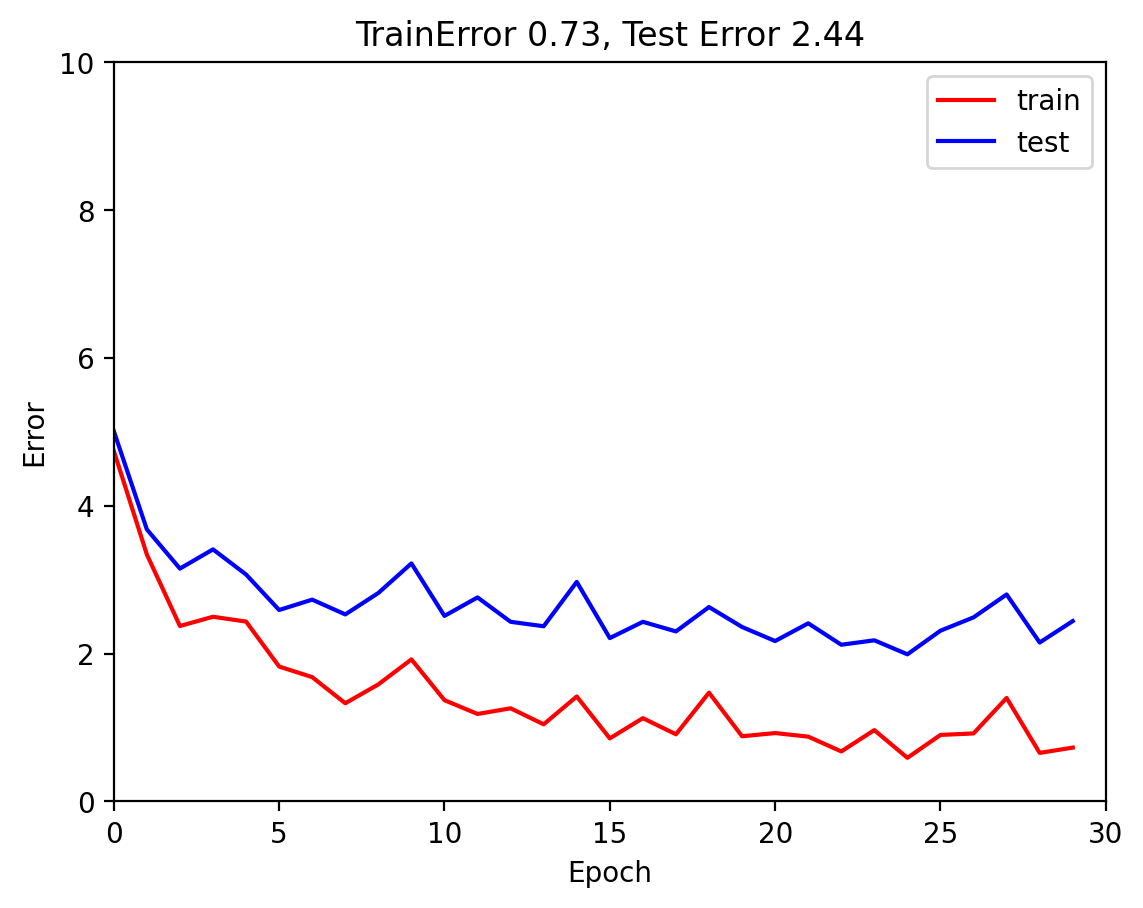

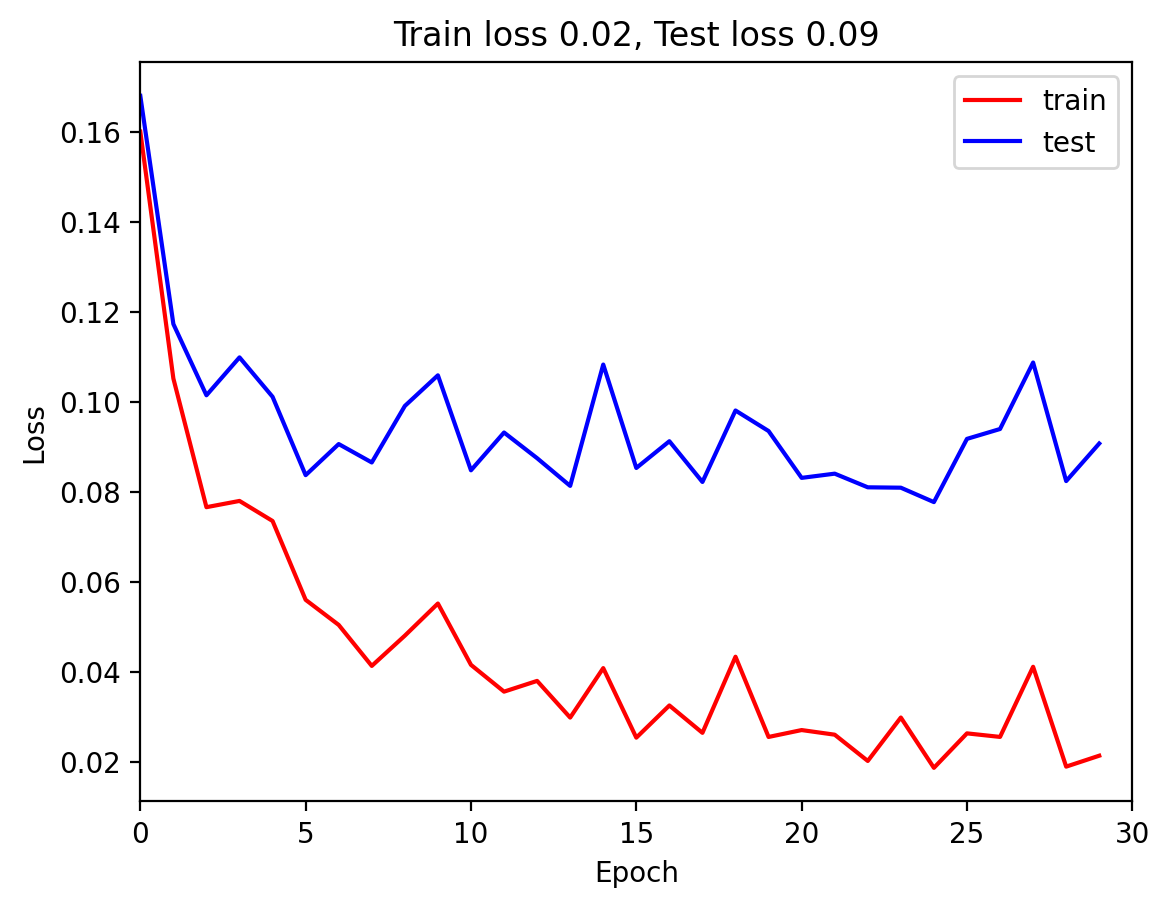

In [ ]:
# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_test,'b-',label='test')
ax.set_ylim(0,10); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('TrainError %3.2f, Test Error %3.2f'%(errors_train[-1],errors_test[-1]))
ax.legend()
plt.show()

# Plot the results
fig, ax = plt.subplots()
ax.plot(losses_train,'r-',label='train')
ax.plot(losses_test,'b-',label='test')
ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
ax.set_title('Train loss %3.2f, Test loss %3.2f'%(losses_train[-1],losses_test[-1]))
ax.legend()
plt.show()